Follows tutorial from here: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html

In [26]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from pathlib import Path

In [37]:

p = Path()
imgpath = p.glob("./Data/*jpg")


imglst = []
for i in imgpath:
    imglst.append(f"{i}")

imglst

['Data/left09.jpg',
 'Data/left01.jpg',
 'Data/left11.jpg',
 'Data/left08.jpg',
 'Data/left05.jpg',
 'Data/left03.jpg',
 'Data/left06.jpg',
 'Data/left14.jpg',
 'Data/left12.jpg',
 'Data/left07.jpg',
 'Data/left04.jpg',
 'Data/left13.jpg',
 'Data/left02.jpg']

## Point correspondences

**This code block is defining points in 3D and finding their corresponding 2D points in each image.** Then we will have known correspondences we can use to solve the camera calibration. 
These points are the corners of the squares of the chessboard, as they will be easy to detect in the images.
The 3D points are assumed known as we use a chessboard of known dimensions. If you have ground truth camera poses you want to compare your results to, then the reference frame should match the one used in that data. But if you don't have ground truth the reference frame is arbitrary so you can just pick one of your points to be the origin and define the other points with respect to it. (Normally for camera calibration you are just trying to find the intrinsics of the camera so it's not necessary to have any particular reference system).
The 2D points are detected using openCV's findChessboardCorners function. 

We use the data from the provided data folder -- these images are from the openCV sample images. If you want to run this with your own images you can give it a try -- note that you need to provide the size of the chessboard pattern as an input to findChessboardCorners and drawChessboardCorners. If the size of the chessboard is different you would also need to modify the objp variable.


In [16]:
np.mgrid[:7,:6].shape

(2, 7, 6)

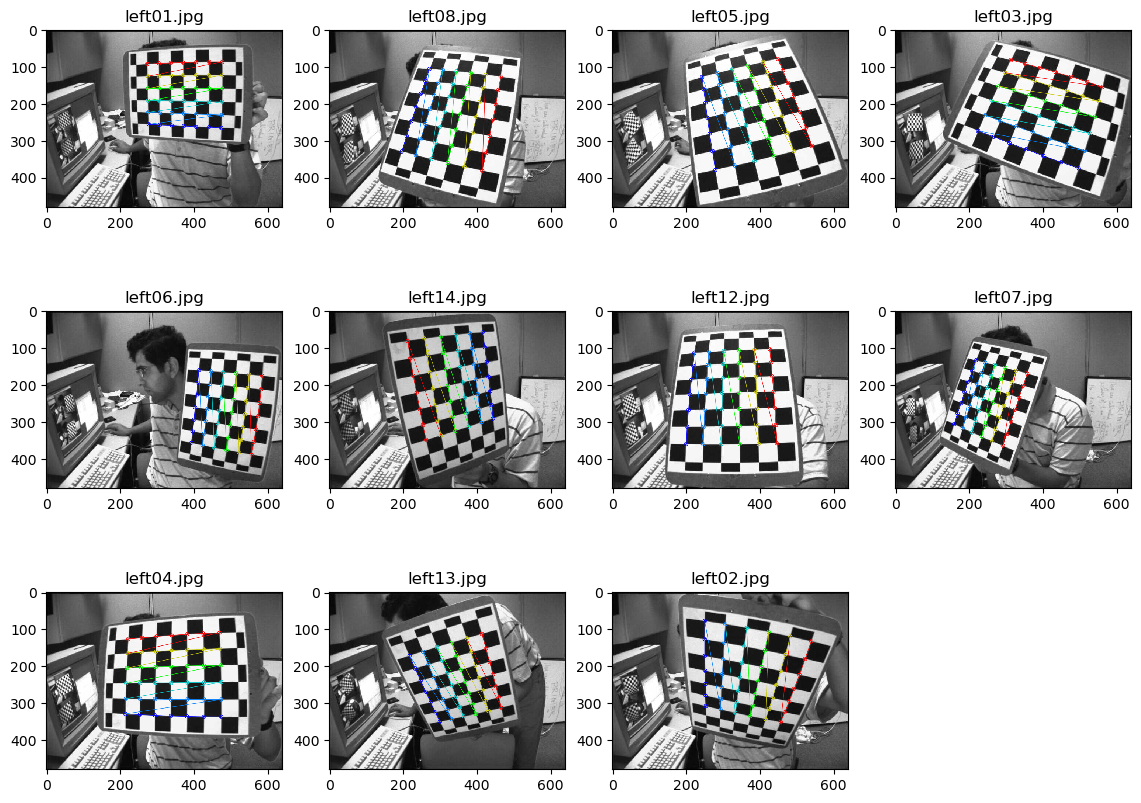

In [67]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*7,3), np.float32)        # (42, 3)
objp[:,:2] = np.mgrid[:7,:6].T.reshape(-1,2)           # [[x,y,z], ...]

objpoints = []  # 3d points in real world space
imgpoints = []  # 2d points in image plane

images = glob.glob("./Data/*.jpg")

fig = plt.figure(figsize=(14,14))
i = 1 
n = len(images)

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1),criteria)   # shape of (42, 1, 2)
        imgpoints.append(corners2)
        cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        plt.subplot(int(np.ceil(n/4)), 4, i)
        plt.imshow(img)
        plt.title(fname.split("/")[-1])
        i+=1

## Calculating the intrinsics

**Now that we have the chessboard corners, we can solve for the camera calibration.** cv2.calibrateCamera takes the 3D (objpoints) and 2D (imgpoints) points we found above, as well as the size of the images. It returns both the camera intrinsics matrix and the extrinsics for each image (i.e. the rotation and translation of the camera, relative to the coordinate system the 3D points were given in).

We display the intrinsics and compare them to those provided in left_intrinsics.yaml (the extrinsics are not the same -- indicating that the frame we defined our 3D points in was not the same as the frame that the ground truth was recorded in).

Note that the intrinsics the openCV camera calibration is solving for are slightly more complicated that the $K$ matrix we have seen in class -- they have radial distortion coefficients as well (see the start of the openCV tutorial we are following for a description of what these distortion coefficients do: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)

In [71]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [51]:
yaml_path = "./Data/left_intrinsics.yaml"
gt = cv2.FileStorage(yaml_path, cv2.FILE_STORAGE_READ) #openCV seems to save its files in a non-standard yaml format so pyyaml can't load them

In [72]:
print("Intrinsics:\n\nGround truth:\n")
print(gt.getNode("camera_matrix").mat())
print("\nEstimated:\n\n", mtx)

print("\n\nDistortion:\n\nGround truth:\n")
print(gt.getNode("distortion_coefficients").mat().flatten())
print("\nEstimated:\n\n", dist.flatten())

Intrinsics:

Ground truth:

[[535.91573396   0.         342.28315473]
 [  0.         535.91573396 235.5708291 ]
 [  0.           0.           1.        ]]

Estimated:

 [[534.07088364   0.         341.53407554]
 [  0.         534.11914595 232.94565259]
 [  0.           0.           1.        ]]


Distortion:

Ground truth:

[-0.26637261 -0.0385889   0.00178319 -0.00028122  0.23839153]

Estimated:

 [-2.92971637e-01  1.07706962e-01  1.31038376e-03 -3.11018780e-05
  4.34798110e-02]


We typically do camera calibration to update or otherwise find a new camera's intrinsics. But here, we can compare to a previously known set of intrinsics.

## Checking our calibration

If we knew the ground truth extrinsics and had the frame they are defined in aligned with the 3D points then we could use the error in those to estimate how bad we expected in the error in the intrisics to be as the intrinsics and extrinsics are calculated together.

However, as it turns out we can do a similar thing without actually having to know any ground truth!

We can simply use the projection equation to project our 3D points back into the image plane and then compare them with the 2D points we detected. This is called the reprojection error.

In [73]:
error_sum = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    error_sum += error
print( "mean error: {}".format(error_sum/len(objpoints)) )

mean error: 0.023686000375385673


We can also estimate how good the **distortion coefficients** we found are through visual inspection. We know that the lines in the chessboard are supposed to be straight, but due to the distortion they are curved in the image. We can use openCV functions (undistort or remapping) along with the distortion coefficients we found to remove this distortion.

In [8]:
img = cv2.imread(images[-1])
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

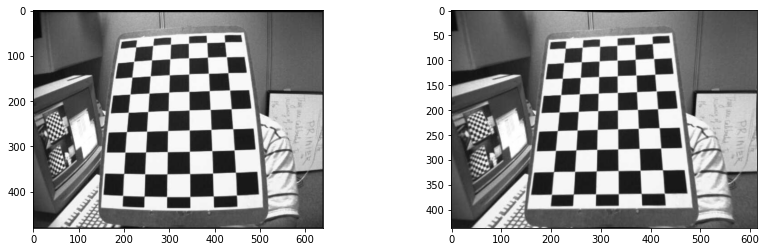

In [9]:
# undistort a single image
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
fig = plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(dst)

Text(0.5, 1.0, 'undistorted with remapping')

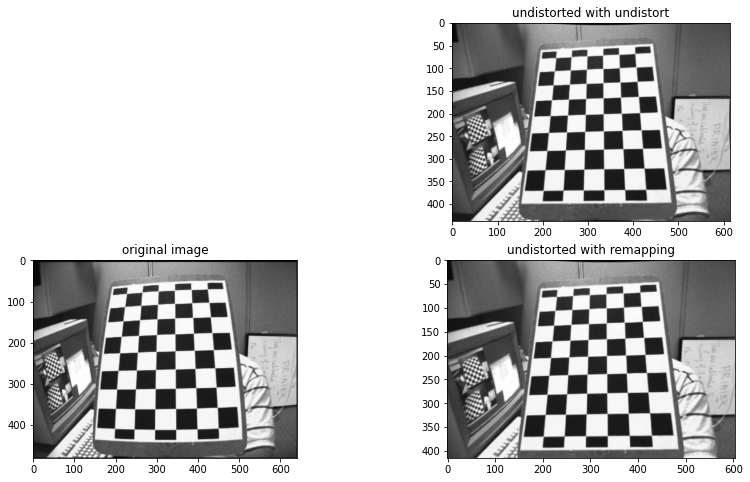

In [10]:
# other undistort functions
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
dst2 = cv2.remap(img, mapx, mapy, cv2.INTER_LINEAR)
# crop the image
x, y, w, h = roi
dst2 = dst2[y:y+h, x:x+w]

fig = plt.figure(figsize=(14, 8))
plt.subplot(2,2,3)
plt.title("original image")
plt.imshow(img)
plt.subplot(2,2,2)
plt.imshow(dst)
plt.title("undistorted with undistort")
plt.subplot(2,2,4)
plt.imshow(dst2)
plt.title("undistorted with remapping")